# Reporting of results sandbox

This notebook is a sandbox for working on the "Reporting of results" section of the review.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('paper')
sns.set_style('white')

In [ ]:
fname = '../data/reporting_results.csv'
df = pd.read_csv(fname, header=0)
df = df.drop(columns=['Unnamed: 0', 'Title', 'Comment'])
df['Result'] = pd.to_numeric(df['Result'], errors='coerce')
df = df.dropna()

In [ ]:
df.tail()

In [ ]:
def extract_model_type(x):
    if 'arch' in x:
        out = 'Proposed'
    elif 'trad' in x:
        out = 'Baseline (traditional)'
    elif 'dl' in x:
        out = 'Baseline (deep learning)'
    else:
        raise ValueError('Model type {} not supported.'.format(x))
    
    return out

df['model_type'] = df['Model'].apply(extract_model_type)

In [ ]:
# Extract accuracy rows only
acc_df = df[df['Metric'] == 'accuracy']

In [ ]:
# Create new column that contains both citation and task information
acc_df['citation_task'] = acc_df[['Citation', 'Task']].apply(lambda x: ' ['.join(x) + ']', axis=1)

# Create a new column with the year
acc_df['year'] = acc_df['Citation'].apply(lambda x: int(x[x.find('2'):x.find('2') + 4]))

In [ ]:
# Order by average proposed model accuracy
# acc_ind = acc_df[acc_df['model_type']=='Proposed'].groupby('Citation').mean().sort_values(by='year').index
acc_ind = acc_df[acc_df['model_type']=='Proposed'].groupby('Citation').mean().sort_values(by='Result').index
acc_df['Citation'] = acc_df['Citation'].astype('category')
acc_df['Citation'].cat.set_categories(acc_ind, inplace=True)
acc_df = acc_df.sort_values(['Citation'])

In [ ]:
acc_df

In [ ]:
# Only keep 2 best per task and model type
acc2_df = acc_df.sort_values(['Citation', 'Task', 'model_type', 'Result'], ascending=True).groupby(
                ['Citation', 'Task', 'model_type']).tail(2)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 18));
sns.catplot(y='citation_task', x='Result', hue='model_type', data=acc2_df, ax=ax);
ax.set_xlabel('accuracy')
ax.set_ylabel('')

## Looking at the difference in accuracy

In [ ]:
# Only keep the maximum accuracy per citation & task
best_df = acc_df.groupby(['Citation', 'Task', 'model_type'])['Result'].max().reset_index()

# Only keep citations/tasks that have a traditional baseline
best_df = best_df.groupby(['Citation', 'Task']).filter(lambda x: 'Baseline (traditional)' in x.values).reset_index()

#  Compute difference between proposed and traditional baseline
diff_df = best_df.groupby(['Citation', 'Task']).apply(
            lambda x: x[x['model_type'] == 'Proposed']['Result'].iloc[0] - \
                      x[x['model_type'] == 'Baseline (traditional)']['Result'].iloc[0]).reset_index()
diff_df = diff_df.rename(columns={0: 'acc_diff'})

In [ ]:
diff_df.describe()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 18));
sns.catplot(y='Task', x='acc_diff', data=diff_df, ax=ax);
ax.set_xlabel('Accuracy difference')
ax.set_ylabel('')
ax.axvline(0, c='k', alpha=0.2)

In [ ]:
fig, ax = plt.subplots()
sns.distplot(diff_df['acc_diff'], kde=False, rug=True, ax=ax)
ax.set_xlabel('Accuracy difference')
ax.set_ylabel('Number of studies')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2))
ax = sns.boxplot(x='acc_diff', data=diff_df)
ax = sns.swarmplot(x='acc_diff', data=diff_df, color="0", alpha=0.6)

In [ ]:
# Pivot dataframe to plot proposed vs. baseline accuracy as a scatterplot
best_df['citation_task'] = best_df[['Citation', 'Task']].apply(lambda x: ' ['.join(x) + ']', axis=1)
acc_comparison_df = best_df.pivot(index='citation_task', columns='model_type', values='Result')

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(data=acc_comparison_df, x='Baseline (traditional)', y='Proposed', ax=ax)
ax.plot([0, 1.1], [0, 1.1], c='k', alpha=0.2)
plt.axis('square')
ax.set_xlim([0, 1.1])
ax.set_ylim([0, 1.1])

## Adding in domain information

In [ ]:
def load_data_items(start_year=2010):
    """Load data items table.

    TODO:
    - Normalize column names?
    - Double check all the required columns are there?
    """
    fname = '../data/data_items.csv'
    df = pd.read_csv(fname, header=1)

    # A little cleaning up
    df = df.dropna(axis=0, how='all')
    df = df.dropna(axis=1, how='all', thresh=int(df.shape[0] * 0.1))
    df = df[df['Year'] >= start_year]

    return df

In [ ]:
data_items_df = load_data_items(start_year=2010)
domains_df = data_items_df.filter(regex='(?=Domain*|Citation)')

In [ ]:
data_items_df.shape[0]

In [ ]:
100 - 100 * data_items_df['Statistical analysis of performance'].value_counts()['No'] / data_items_df.shape[0]

In [ ]:
# Concatenate domains into one string
def concat_domains(x):
    domain = ''
    for i in x[1:]:
        if isinstance(i, str):
            domain += i + '/'
    return domain[:-1]

domains_df['domain'] = data_items_df.filter(regex='(?=Domain*)').apply(concat_domains, axis=1)

In [ ]:
diff_domain_df = diff_df.merge(domains_df, on='Citation', how='left')
diff_domain_df = diff_domain_df.sort_values(by='domain')
diff_domain_df.head()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 8));
sns.catplot(y='domain', x='acc_diff', jitter=True, data=diff_domain_df, ax=ax);
ax.set_xlabel('Accuracy difference')
ax.set_ylabel('')
ax.axvline(0, c='k', alpha=0.2)

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(6, 50))
gs1 = gridspec.GridSpec(6, 1)
gs1.update(hspace=0.025) # set the spacing between axes. 

ax1 = plt.subplot(gs1[0])
sns.catplot(y='domain', x='acc_diff', size=3, jitter=True, data=diff_domain_df, ax=ax1);
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.axvline(0, c='k', alpha=0.2)

ax2 = plt.subplot(gs1[1])
sns.boxplot(x='acc_diff', data=diff_df, ax=ax2)
sns.swarmplot(x='acc_diff', data=diff_df, color="0", size=3, ax=ax2)
ax2.axvline(0, c='k', alpha=0.2)
ax2.set_xlabel('Accuracy difference')

In [ ]:
diff_df.nlargest(1, 'acc_diff')['Citation'].values[0]

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(6, 8), gridspec_kw = {'height_ratios':[5, 1]});

sns.catplot(y='domain', x='acc_diff', size=3, jitter=True, data=diff_domain_df, ax=axes[0]);
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].axvline(0, c='k', alpha=0.2)

sns.boxplot(x='acc_diff', data=diff_df, ax=axes[1])
sns.swarmplot(x='acc_diff', data=diff_df, color="0", size=3, ax=axes[1])
axes[1].axvline(0, c='k', alpha=0.2)
axes[1].set_xlabel('Accuracy difference')

fig.subplots_adjust(wspace=0, hspace=0.02)

iqr = diff_df['acc_diff'].quantile(.75) - diff_df['acc_diff'].quantile(.25)
print(diff_df['acc_diff'].describe())
print('iqr\t{:.6f}'.format(iqr))

## Inspection/visualization techniques

In [ ]:
# Separate rows that contain multiple values into multiple rows
def lstrip(list_of_strs):
    """Remove left space and make lowercase."""
    return [a.lstrip().lower() for a in list_of_strs] 

data_items_df['inspection_list'] = data_items_df['Model inspection (clean)'].str.split(',').apply(lstrip)

inspection_per_article = list()
for i, items in data_items_df[['Citation', 'inspection_list']].iterrows():
    for m in items['inspection_list']:
        inspection_per_article.append([i, items['Citation'], m])
        
inspection_df = pd.DataFrame(inspection_per_article, columns=['paper nb', 'Citation', 'inspection method'])

# Replace "no" by "None"
inspection_df['inspection method'][inspection_df['inspection method'] == 'no'] = 'None'

In [ ]:
inspection_df.head()

In [ ]:
(inspection_df['inspection method'].value_counts() / inspection_df.shape[0])['None'] 

In [ ]:
# Removing low count categories
cutoff = 1

inspection_counts = inspection_df['inspection method'].value_counts()
inspection_df = inspection_df[inspection_df['inspection method'].isin(
    inspection_counts[(inspection_counts >= cutoff)].index)]

fig, ax = plt.subplots(figsize=(10, 7))
ax = sns.countplot(y='inspection method', data=inspection_df, 
                   order=inspection_df['inspection method'].value_counts().index)
ax.set_xlabel('Number of papers')
ax.set_ylabel('')
plt.tight_layout()

In [ ]:
# Percentages
inspection_df['inspection method'].value_counts() / len(np.unique(inspection_df['Citation']))

In [ ]:
# List of citations per category
inspection_categories = inspection_df.groupby('inspection method')['Citation'].apply(list)
inspection_categories['generating input to maximize activation']

## Origin

In [ ]:
fig, ax = plt.subplots()
sns.countplot(data_items_df['Type of paper'], ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Number of papers')

print(data_items_df['Type of paper'].value_counts())

In [ ]:
fig, ax = plt.subplots()
sns.countplot(data_items_df[data_items_df['Type of paper'] != 'Preprint']['Preprint first'])
ax.set_ylabel('Number of papers')

print(data_items_df[data_items_df['Type of paper'] != 'Preprint']['Preprint first'].value_counts())

In [ ]:
fig, ax = plt.subplots(figsize=(7, 30))
sns.countplot(y=data_items_df['Journal / Origin'], ax=ax,
              order=data_items_df['Journal / Origin'].value_counts().index)
ax.set_xlim([0, 5])

In [ ]:
fig, ax = plt.subplots()
sns.countplot(y=data_items_df['Country'], ax=ax,
              order=data_items_df['Country'].value_counts().index)
ax.set_xlabel('Number of papers')
ax.set_ylabel('')

In [ ]:
fig, ax = plt.subplots()
sns.countplot(y=data_items_df['Pages'], ax=ax,
              order=data_items_df['Pages'].value_counts().index)
ax.set_xlabel('Number of papers')
ax.set_ylabel('')

### Authors

In [ ]:
# Separate rows that contain multiple values into multiple rows
def lstrip(list_of_strs):
    """Remove left space and make lowercase."""
    return [a.lstrip().lower() for a in list_of_strs] 

data_items_df['authors'] = data_items_df['Authors'].str.replace(' &', ',').str.split(',').apply(lstrip)

authors_per_article = list()
for i, items in data_items_df[['Citation', 'authors']].iterrows():
    for m in items['authors']:
        authors_per_article.append([i, items['Citation'], m])
        
authors_df = pd.DataFrame(authors_per_article, columns=['paper nb', 'Citation', 'author'])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 40))
sns.countplot(y=authors_df['author'], ax=ax,
              order=authors_df['author'].value_counts().index)
ax.set_xlabel('Number of papers')
ax.set_ylabel('')

## Developing new bar graph to replace pie charts

## Making domains vs. architectures table

In [ ]:
data_items_df = load_data_items(start_year=2010)
data_items_df.head()

In [ ]:
def replace_nans_in_column(df, column_name, replace_by=' '):
    nan_ind = df[column_name].apply(lambda x: np.isnan(x) if isinstance(x, float) else False)
    df.loc[nan_ind, column_name] = replace_by
    return df
    
# Replace NaNs by ' ' in 'Domain 3' and 'Domain 4' columns
data_items_df = replace_nans_in_column(data_items_df, 'Domain 3', replace_by=' ')
data_items_df = replace_nans_in_column(data_items_df, 'Domain 4', replace_by=' ')

In [ ]:
# Add escape character in front of characters that happen to be special LaTeX characters
import re

def tex_escape(text):
    """
        :param text: a plain text message
        :return: the message escaped to appear correctly in LaTeX
        
        From https://stackoverflow.com/a/25875504
    """
    conv = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(str(key)) for key in sorted(conv.keys(), key = lambda item: - len(item))))
    return regex.sub(lambda match: conv[match.group()], text)

cols = ['Domain 1', 'Domain 2', 'Domain 3', 'Domain 4', 'Architecture (clean)']
data_items_df[cols] = data_items_df[cols].applymap(tex_escape)

In [ ]:
# Make tuple of first 2 domain levels
domains_df = data_items_df.groupby(['Domain 1', 'Domain 2', 'Domain 3', 'Domain 4', 'Architecture (clean)'])[
                'Citation'].apply(list).apply(lambda x: '\cite{' + ', '.join(x) + '}').unstack()

domains_df = domains_df.applymap(lambda x: ' ' if isinstance(x, float) and np.isnan(x) else x)

with open('domains_architecture_table.tex', 'w') as f:
    with pd.option_context("max_colwidth", 1000):
        f.write(domains_df.to_latex(escape=False, column_format='p{1.5cm}' * 4 + 'p{0.6cm}' * domains_df.shape[1]))

In [ ]:
domains_df

## PRISMA diagram

In [ ]:
from graphviz import Digraph

In [ ]:
dot = Digraph(format='eps')
dot.attr('graph', rankdir='TB', overlap='false')
dot.attr('node', fontname='Liberation Sans', fontsize=str(10), shape='box', style='filled',
         margin='0.2,0.01', penwidth='0.5')

fillcolor = 'gray98'

dot.node('A', 'PubMed (n=39)\nGoogle Scholar (n=409)\narXiv (n=105)', fillcolor=fillcolor)
dot.node('B', 'Articles identified\nthrough database\nsearching\n(n=553)', fillcolor=fillcolor)
# dot.node('B2', 'Excluded\n(n=446)', fillcolor=fillcolor)
dot.node('C', 'Articles after content\nscreening and\nduplicate removal\n(n=107) ', fillcolor=fillcolor)
dot.node('D', 'Articles included in\nthe analysis\n(n=156)', fillcolor=fillcolor)
dot.node('E', 'Additional articles\nidentified through\nbibliography search\n(n=49)', fillcolor=fillcolor)

dot.edge('B', 'C')
# dot.edge('B', 'B2')
dot.edge('C', 'D')
dot.edge('E', 'D')

dot

## Number of subjects

In [ ]:
def lstrip(list_of_strs, lower=True):
    """Remove left space and make lowercase."""
    return [a.lstrip().lower() if lower else a.lstrip() for a in list_of_strs]


def split_column_with_multiple_entries(df, col, ref_col='Citation', sep=';\n', lower=True):
    """Split the content of a column that contains more than one value per cell.
    
    Split the content of cells that contain more than one value. Some cells 
    contain two or more values for a single data item, e.g., 
        
        Number of subjects: '15, 203, 23'
        
    A DataFrame where each row contains a single value per cell is returned.
    
    Args:
        df (pd.DataFrame)
        col (str): name of the column to split
        
    Keyword Args:
        ref_col (str): identifier column to use to identify the row of
            origin of a splitted value.
        sep (str): separator between multiple values
        lower (bool): if True, make all values lowercase
        
    Returns:
        (pd.DataFrame)
    """
    df['temp'] = df[col].str.split(sep).apply(lstrip, lower=lower)
    
    value_per_row = list()
    for i, items in df[[ref_col, 'temp']].iterrows():
        for m in items['temp']:
            value_per_row.append([i, items[ref_col], m])

    return pd.DataFrame(value_per_row, columns=['paper nb', ref_col, col])

In [ ]:
# Extract main domains
main_domains = ['Epilepsy', 'Sleep', 'BCI', 'Affective', 'Cognitive', 
                'Improvement of processing tools', 'Generation of data']
domains_df = data_items_df[['Domain 1', 'Domain 2', 'Domain 3', 'Domain 4']]
data_items_df['Main domain'] = [row[row.isin(main_domains)].values[0] 
    if any(row.isin(main_domains)) else 'Others' 
    for ind, row in domains_df.iterrows()]

# Split values into separate rows and remove invalid values
nb_subj_df = split_column_with_multiple_entries(data_items_df, 'Data - subjects', ref_col='Main domain')
nb_subj_df['Data - subjects'] = nb_subj_df['Data - subjects'].astype(int)
nb_subj_df = nb_subj_df.loc[nb_subj_df['Data - subjects'] > 0, :]

fig, ax = plt.subplots()
ax.set(xscale='log', yscale='linear')
sns.swarmplot(y='Main domain', x='Data - subjects', data=nb_subj_df, ax=ax, size=1,
            order=nb_subj_df.groupby(['Main domain'])['Data - subjects'].median().sort_values().index)
ax.set_xlabel('Number of subjects')
ax.set_ylabel('')

## Number of EEG channels and hardware

In [ ]:
# 2) Extract # channels
# 3) Make matrix
# 4) Plot

In [ ]:
# Extract vendor
hardware_df = split_column_with_multiple_entries(
    data_items_df, 'EEG Hardware', ref_col='Citation', sep=',', lower=False)

def extract_vendor_from_hardware(s):
    if s != 'N/M':
        return s[s.find('(') + 1:s.find(')')]
    else:
        return 'N/M'
    
hardware_df['vendor'] = hardware_df['EEG Hardware'].apply(extract_vendor_from_hardware)
hardware_df.shape

In [ ]:
nb_channels_df = split_column_with_multiple_entries(
    data_items_df, 'Nb Channels', ref_col='Citation', sep=';\n', lower=False)
nb_channels_df['Nb Channels'] = nb_channels_df['Nb Channels'].astype(int)
nb_channels_df = nb_channels_df.loc[nb_channels_df['Nb Channels'] > 0, :]

fs_df = split_column_with_multiple_entries(
    data_items_df, 'Sampling rate', ref_col='Citation', sep=';\n', lower=False)
fs_df['Sampling rate'] = fs_df['Sampling rate'].astype(float)
fs_df = fs_df.loc[fs_df['Sampling rate'] > 0, :]

In [ ]:
device_fs_df = fs_df[['Sampling rate']]
device_fs_df = device_fs_df.rename(columns={'Sampling rate': 'value'})
device_fs_df['type'] = 'Sampling rate'

In [ ]:
device_ch_df = nb_channels_df[['Nb Channels']]
device_ch_df = device_ch_df.rename(columns={'Nb Channels': 'value'})
device_ch_df['type'] = 'Number of channels'

In [ ]:
fig, ax = plt.subplots()
sns.distplot(nb_channels_df['Nb Channels'], kde=False, norm_hist=False, ax=ax)
ax.set_xlabel('Number of EEG channels')
ax.set_ylabel('Number of papers')

## Cross-validation

In [ ]:
data_items_df = load_data_items()

In [ ]:
data_items_df[col] = data_items_df[col].fillna('N/M')
data_items_df[col].unique()

In [ ]:
col = 'Cross validation (clean)'
data_items_df[col] = data_items_df[col].fillna('N/M')
cv_df = split_column_with_multiple_entries(
    data_items_df, col, ref_col='Citation', sep=';\n', lower=False)

In [ ]:
cv_df[col].value_counts().index

In [ ]:
sns.countplot(y=cv_df[col], order=cv_df[col].value_counts().index)

## Intra vs intersubject

In [ ]:
data_items_df['Intra/Inter subject'].value_counts()

In [ ]:
col = 'Intra/Inter subject'
counts = data_items_df.groupby(['Year', col]).size().unstack(col)
order = data_items_df[col].value_counts().index
counts = counts[order]
counts.plot(kind='bar', stacked=True, title='')
ax.legend()

## Dataset table

In [ ]:
def split_column_with_multiple_entries(df, col, ref_col='Citation', sep=';\n', lower=True):
    """Split the content of a column that contains more than one value per cell.
    
    Split the content of cells that contain more than one value. Some cells 
    contain two or more values for a single data item, e.g., 
        
        Number of subjects: '15, 203, 23'
        
    A DataFrame where each row contains a single value per cell is returned.
    
    Args:
        df (pd.DataFrame)
        col (str): name of the column to split
        
    Keyword Args:
        ref_col (str or list of str): identifier column(s) to use to identify 
            the row of origin of a splitted value.
        sep (str): separator between multiple values
        lower (bool): if True, make all values lowercase
        
    Returns:
        (pd.DataFrame)
    """
    df['temp'] = df[col].str.split(sep).apply(lstrip, lower=lower)
    
    if not isinstance(ref_col, list):
        ref_col = [ref_col]
    
    value_per_row = list()
    for i, items in df[[*ref_col, 'temp']].iterrows():
        for m in items['temp']:
            value_per_row.append([i, *items[ref_col].tolist(), m])

    return pd.DataFrame(value_per_row, columns=['paper nb', *ref_col, col])

## Data

In [2]:
import sys
sys.path.append('/home/hubert/Documents/dl-eeg-review/code/')
import utils as ut

import numpy as np

In [3]:
data_items_df = ut.load_data_items(start_year=2010)
data_items_df = ut.extract_main_domains(data_items_df)

### Data (samples)

In [4]:
col = 'Data - samples'
samples_df = ut.split_column_with_multiple_entries(
    data_items_df, col, ref_col=['Citation', 'Main domain', 'ref_nb'], sep=';\n', lower=False)

# Remove N/M and TBD
samples_df = samples_df.loc[~samples_df[col].isin(['N/M', 'TBD', '[TBD]'])]
samples_df[col] = samples_df[col].astype(int)
samples_df = samples_df.sort_values(['Main domain', col])

In [5]:
col2 = 'Data - time'
time_df = ut.split_column_with_multiple_entries(
    data_items_df, col2, ref_col=['Citation', 'Main domain', 'Authors'], sep=';\n', lower=False)

# Remove weird cells
time_df = time_df.loc[time_df[col2].apply(len) < 20, :]

# Remove N/M and TBD
time_df = time_df.loc[~time_df[col2].isin(['N/M', 'TBD', '[TBD]'])]
time_df[col2] = time_df[col2].astype(float)
time_df = time_df.sort_values(by=col2)
time_df = time_df.sort_values(['Main domain', col2])

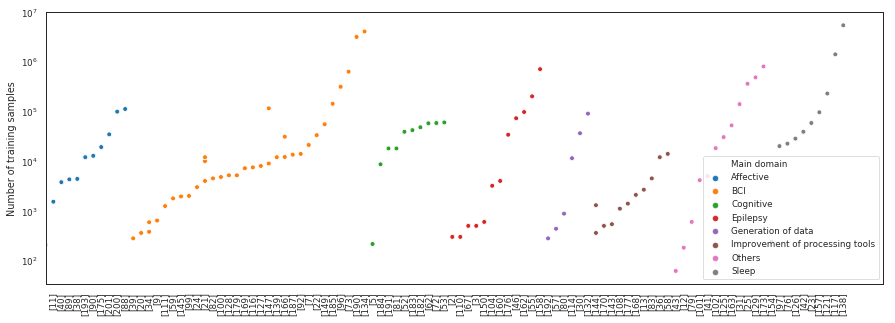

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set(xscale='linear', yscale='log')
sns.scatterplot(x='ref_nb', y=col, hue='Main domain', data=samples_df, ax=ax)
ax.set_ylabel('Number of training samples')
ax.set_xlabel('')
ax.set_xlim([0.1, None])
plt.xticks(rotation='vertical'); # plt.tight_layout()

ax.set_yticks(np.power(10, [2, 3, 4, 5, 6, 7]))

from matplotlib.ticker import ScalarFormatter
# ax.yaxis.set_major_formatter(ScalarFormatter())

In [ ]:
fig, ax = plt.subplots(figsize=(5, 15))
ax.set(xscale='log', yscale='linear')
sns.scatterplot(y='ref_nb', x=col, hue='Main domain', data=samples_df, ax=ax)
ax.set_xlabel('Number of training samples')
ax.set_ylabel('')
ax.set_ylim([0.1, None])
# plt.xticks(rotation='vertical'); # plt.tight_layout()

### Data (time)

In [ ]:
col2 = 'Data - time'
time_df = ut.split_column_with_multiple_entries(
    data_items_df, col2, ref_col=['Citation', 'Main domain', 'Authors'], sep=';\n', lower=False)

# Remove weird cells
time_df = time_df.loc[time_df[col2].apply(len) < 20, :]

# Remove N/M and TBD
time_df = time_df.loc[~time_df[col2].isin(['N/M', 'TBD', '[TBD]'])]
time_df[col2] = time_df[col2].astype(float)
time_df = time_df.sort_values(by=col2)
time_df = time_df.sort_values(['Main domain', col2])

In [ ]:
time_df.head()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 12))
ax.set(xscale='log', yscale='linear')
sns.scatterplot(y='Citation', x=col2, hue='Main domain', data=time_df, ax=ax)
ax.set_xlabel('Time (min)')
ax.set_ylabel('')
ax.set_xlim([1, None])
# plt.tight_layout()

### Merging sampling and time information (univariate plots)

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 12))

axes[0].set(xscale='log', yscale='linear')
sns.scatterplot(y='Citation', x=col, hue='Main domain', data=samples_df, ax=axes[0])
axes[0].set_xlabel('Number of training samples')
axes[0].set_ylabel('')
axes[0].set_xlim([1, None])


inds = samples_df.index

axes[1].set(xscale='log', yscale='linear')
sns.scatterplot(y='Citation', x=col2, hue='Main domain', data=time_df.iloc[inds], ax=axes[1])
axes[1].set_xlabel('Time (min)')
axes[1].set_ylabel('')
axes[1].set_xlim([1, None])

plt.tight_layout()

### Merging samples and time information (bivariate plot)

In [ ]:
data_df['data_ratio'] = data_df['Data - samples'] / data_df['Data - time']
data_df = data_df.sort_values(['Main domain', 'data_ratio'])

fig, ax = plt.subplots(figsize=(9.5, 11))
sns.scatterplot(x='data_ratio', y='Citation', hue='Main domain', data=data_df)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.scatterplot(x='Data - samples', y='Data - time', hue='Main domain', s=30, data=data_df, ax=ax)
ax.set(xscale='log', yscale='log')
ax.set_xlabel('Number of training samples')
ax.set_ylabel('Time (min)')
ax.set_title('Amount of data used in studies')
# plt.axis('square')

## Extract reference numbers from .bbl file

In [ ]:
import re

In [ ]:
def extract_ref_numbers_from_bbl(df, filename=None):
    """Extract reference numbers from .bbl file and add them to df.
    
    Args:
        df (pd.DataFrame): dataframe containing the data items
            spreadsheet.
    
    Keyword Args:
        filename (str): path to the .bbl file (created when compiling
            the main tex file).
            
    Returns:
        (pd.DataFrame): dataframe with new column 'ref_nb'.
    """
    filename = '../data/output.bbl'
    with open(filename, 'r', encoding = 'ISO-8859-1') as f:
        text = ''.join(f.readlines())

    ref_nbs = re.findall(r'\\bibitem\{(.*)\}', text)
    ref_dict = {ref: i + 1 for i, ref in enumerate(ref_nbs)}

    df['ref_nb'] = df['Citation'].apply(lambda x: '[{}]'.format(ref_dict[x]))

    return df

In [ ]:
data_items_df = extract_ref_numbers_from_bbl(data_items_df)
data_items_df